In [20]:
from __future__ import print_function
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from math import sqrt
import sklearn
from sklearn.linear_model import LogisticRegression
import pickle
import time
import torch

from utils import test_accuracy, projection, veccos, binary_search_cx, \
                  find_exp_score, find_slab_score, project_l2_centroid, \
                  project_l2_centroid_straight, project_slab, project_slab_straight,\
                  contaminate_dataset

from attackers import StraightAttack, SemiOnlineAttack, ConcentratedAttack, GreedyAttack

In [21]:
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24

In [22]:
def plotting(datasets, defense_method, defense_ranges, attacks, n_contam_level=0, yrange=[0,1]):

    fig, ax = plt.subplots(nrows=len(defense_ranges), ncols=len(datasets), 
                           sharex=False, sharey=True, figsize=(20,6))
    plt.ylim(yrange)
    plt.subplots_adjust(wspace=2)
    colors = []
    for range_idx, defense_range in enumerate(defense_ranges):

        for k,dataset in enumerate(datasets):
            for attack_method in attacks:
                filepath = "_".join(["./results/", dataset, attack_method, defense_method, defense_range])
                with open(filepath, "rb") as f:
                    results = pickle.load(f)
                res, w_res, acc_res, taus, contamination_levels = results
                for i,level in enumerate(contamination_levels[:n_contam_level+1]):
                    ax[range_idx][k].plot([item for item in taus], res[i], 
                                          marker="s", color=colors[attack_method], 
                               label='{}'.format(attack_method), linewidth=2, markersize=8)
            if range_idx<(len(defense_ranges)-1):
                ax[range_idx][k].set_xticks([])
            if range_idx==0:
                ax[range_idx][k].xaxis.set_label_position('top') 
                ax[range_idx][k].set_xlabel(dataset, fontsize=24)
                
           
    fig.text(0.5, -0.02, r'Defense Parameter $\tau$', ha='center', va='center', fontsize=24)
    fig.text(-0.02, 0.5, 'Test Accuracy after Attacks', ha='center', va='center', rotation='vertical', fontsize=24)
    fig.legend(["Greedy", "Concentrated", "Straight", "Semi-Online"], bbox_to_anchor=(0.2, 1.02, 0.6, .12), loc=2,
           ncol=4, mode="expand", borderaxespad=0., fontsize=20)

    plt.tight_layout()
    plt.show()

In [23]:
def plotting_by_defense(datasets, defense_methods, defense_range, attacks, n_contam_level=0, yrange=[-1,1], metric="cos"):

    fig, ax = plt.subplots(nrows=len(defense_methods), ncols=len(datasets), 
                           sharex=False, sharey=True, figsize=(20,9))
    plt.ylim(yrange)
    plt.subplots_adjust(wspace=2)
    colors = {"simplistic": "b", "greedy": "g", "semi-online": "r", "concentrated":"c"}
    thres = {('MNIST', 'norm'): (0, 0), ('MNIST', 'L2'): (2.028869063172743, 2.6215456), 
             ('MNIST', 'slab'): (13.745005, 13.745005), ('fashionMNIST', 'norm'): (0, 0), 
             ('fashionMNIST', 'L2'): (1.9579202156108244, 3.663913268613263), 
             ('fashionMNIST', 'slab'): (27.119718060445148, 27.119718060445148), 
             ('IMDB', 'norm'): (0, 0), ('IMDB', 'L2'): (0.3837587052778431, 0.40768197), 
             ('IMDB', 'slab'): (0.33631036, 0.33631036), 
             ('BreastCancer', 'norm'): (0, 0), 
             ('BreastCancer', 'L2'): (0.6381748919186886, 0.6415767327968535), 
             ('BreastCancer', 'slab'): (1.372069013554284, 1.372069013554284)}
    
    defense_txt = {"slab":r"Slab", 
           "norm":r"$L_2$-norm", 
           "L2":r"$L_2$ distance"+ "\n to centroid"}
    data_txt = {"MNIST":"MNIST", 
           "fashionMNIST":r"FashionMNIST", 
           "BreastCancer":r"BreastCancer",
                  "IMDB":"IMDB"}
    
    for defense_idx, defense_method in enumerate(defense_methods):
        
        for k,dataset in enumerate(datasets):
            for attack_method in attacks:
                filepath = "_".join(["./results/", dataset, attack_method, defense_method, defense_range])
                with open(filepath, "rb") as f:
                    results = pickle.load(f)
                res, w_res, acc_res, taus, contamination_levels, thres = results 
                for i,level in enumerate(contamination_levels[:n_contam_level+1]):
                    if metric=="cos":
                        res[i] = [item*(-1) for item in res[i]]
                    else:
                        res[i] = [1-item for item in acc_res[i]]
                    for j,item in enumerate(res[i]):
                        if j>0:
                            res[i][j] = max(res[i][j], res[i][j-1])
                    
                    ax[defense_idx][k].plot([item for item in taus], res[i], 
                                            marker="s", color=colors[attack_method], 
                               label='{}'.format(attack_method), linewidth=3, markersize=8)
                    
                    low, high = thres
                    ax[defense_idx][k].axvspan(0, min(low, taus[-1]), facecolor='r', alpha=0.05)
                    ax[defense_idx][k].axvspan(min(high, taus[-1]), taus[-1], facecolor='b', alpha=0.05)

            if defense_idx==0:
                ax[defense_idx][k].xaxis.set_label_position('top') 
                ax[defense_idx][k].set_xlabel(data_txt[dataset], fontsize=24)
            if k==0:
                ax[defense_idx][k].yaxis.set_label_position('left') 
                ax[defense_idx][k].set_ylabel(defense_txt[defense_method], fontsize=24)
                
    txt = {"concentrated":"Concentrated", 
           "greedy":"Greedy", 
           "simplistic":"Simplistic", 
           "semi-online":"Semi-Online-WK"} 

    fig.text(0.5, -0.02, r'Defense Parameter $\tau$', ha='center', va='center', fontsize=28)
    if metric=="cos":
        fig.text(-0.01, 0.5, r'Cosine value between $\theta$ and $\theta^*$', ha='center', va='center', rotation='vertical', fontsize=28)
    else:
        fig.text(-0.01, 0.5, r'Error Rate of $\theta$ on Clean Test Set', ha='center', va='center', rotation='vertical', fontsize=28)
    fig.legend([txt[attack] for attack in attacks], bbox_to_anchor=(0.3, 1.05, 0.5, .12), loc=5,
           ncol=2, mode="expand", borderaxespad=0., fontsize=24)
    plt.tight_layout()
    plt.show()

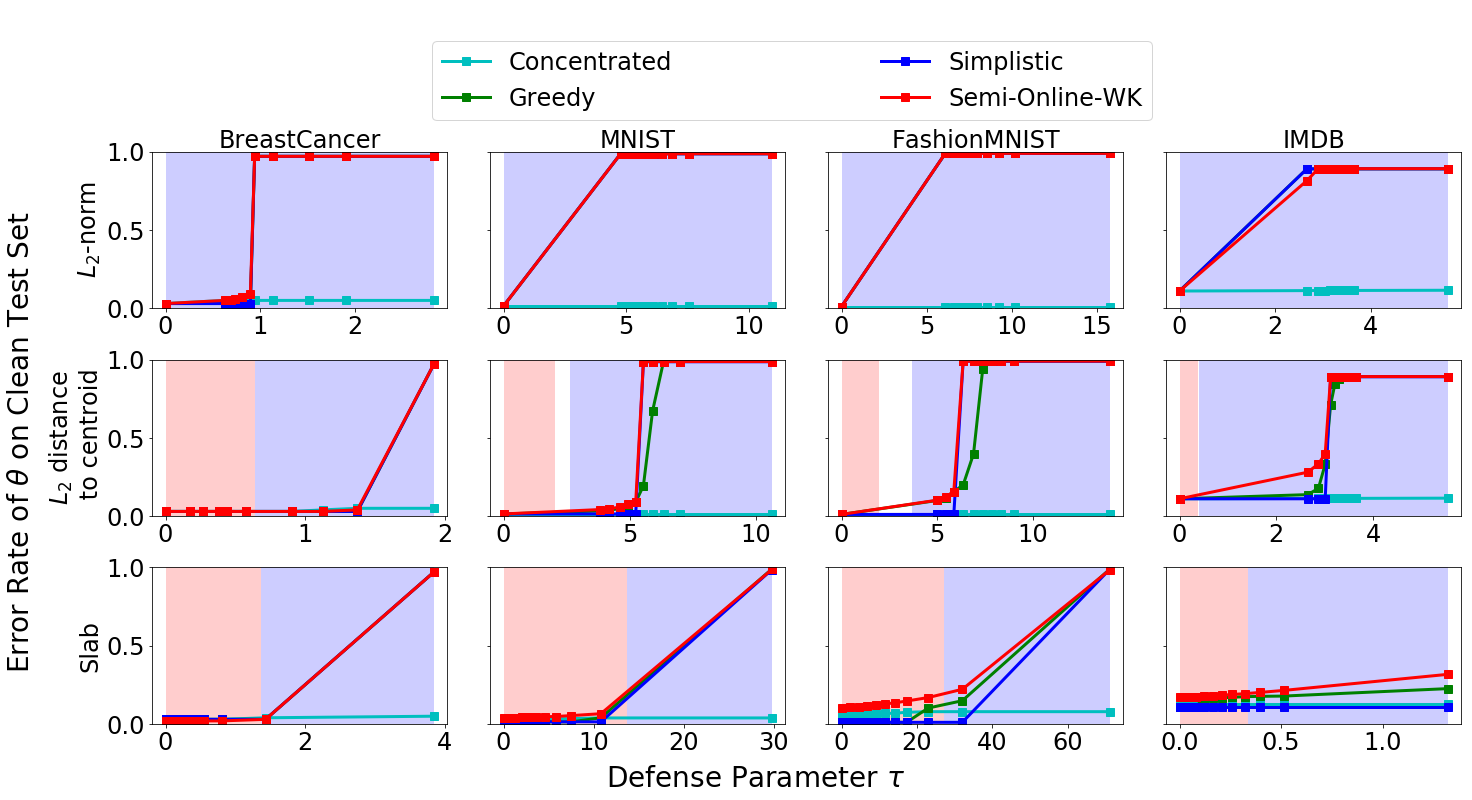

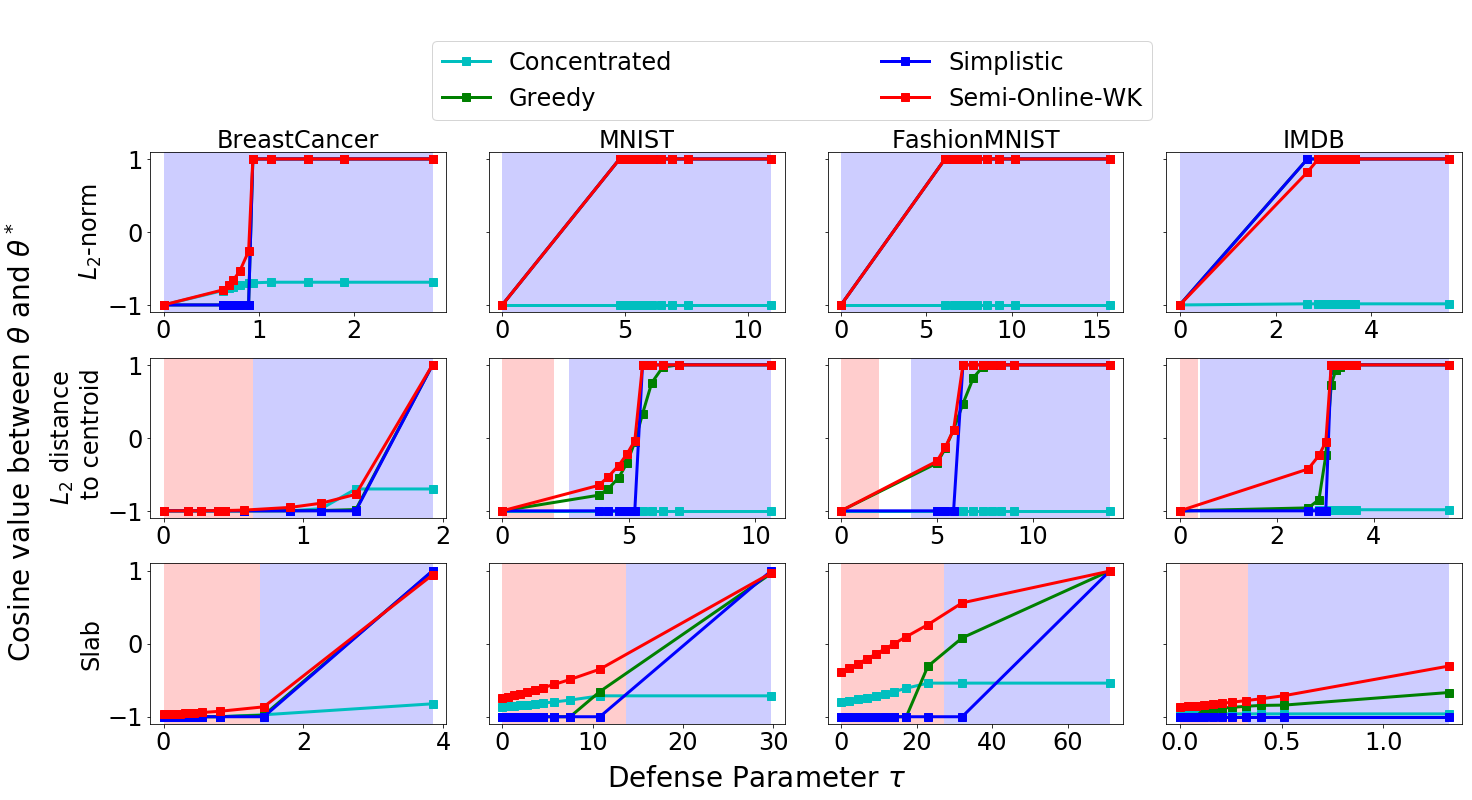

In [24]:
datasets = ["BreastCancer", "MNIST", "fashionMNIST", "IMDB"]
defense_methods = ["norm", "L2", "slab"]
attacks = ["concentrated", "greedy", "simplistic", "semi-online"]

defense_range = "att-only"
plotting_by_defense(datasets, defense_methods, defense_range, attacks, yrange=[0,1], metric="acc")
plotting_by_defense(datasets, defense_methods, defense_range, attacks, yrange=[-1.1,1.1])